In [ ]:
"""
COMP 559 Homework 3 Non-linear Embedding

"""

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from os import sys
sys.path.append("../../../graph_tools")
sys.path.append("../../../../python_tools/python_tools/")
sys.path.append("../../../../machine_learning_tools/machine_learning_tools/")

In [4]:
import networkx_utils as xu
import graph_statistics as gs
import graph_preprocessing as gpre
import graph_visualizations as gviz
import networkx as nx
import matplotlib.pyplot as plt

# Importing the MNIST dataset

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import h5py 
from functools import reduce
def hdf5(path,
         data_key = "data", 
         target_key = "target", 
         flatten = True):
    """
        loads data from hdf5: 
        - hdf5 should have 'train' and 'test' groups 
        - each group should have 'data' and 'target' dataset or spcify the key
        - flatten means to flatten images N * (C * H * W) as N * D array
    """
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get(data_key)[:]
        y_tr = train.get(target_key)[:]
        test = hf.get('test')
        X_te = test.get(data_key)[:]
        y_te = test.get(target_key)[:]
        if flatten:
            X_tr = X_tr.reshape(X_tr.shape[0], reduce(lambda a, b: a * b, X_tr.shape[1:]))
            X_te = X_te.reshape(X_te.shape[0], reduce(lambda a, b: a * b, X_te.shape[1:]))
    return X_tr, y_tr, X_te, y_te

In [6]:
X_tr, y_tr, X_te, y_te = hdf5("./usps.h5")
X_tr.shape, X_te.shape

((7291, 256), (2007, 256))

In [32]:
import pandas as pd
import pandas_ml as pdml

target_name = "y"

df_train = pd.DataFrame(X_tr)
df_train[target_name] = y_tr
df_test = pd.DataFrame(X_te)
df_test[target_name] = y_te
df_test

X_train,y_train = pdml.X_y(df_train,target_name=target_name)
X_test,y_test = pdml.X_y(df_test,target_name=target_name)

X_train

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.1845,0.9310,0.4165,...,0.6520,0.9115,1.0000,0.7410,0.2630,0.0045,0.0000,0.0000,0.000,0.0
1,0.0,0.0,0.0,0.0935,0.1645,0.0955,0.0565,0.1645,0.0735,0.0000,...,0.1645,0.1645,0.4835,0.8805,0.8810,0.5630,0.4525,0.1645,0.086,0.0
2,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0020,...,0.0000,0.0000,0.0000,0.4455,1.0000,0.4105,0.0000,0.0000,0.000,0.0
3,0.0,0.0,0.0,0.0000,0.0000,0.3635,0.8420,0.9800,0.7250,0.4665,...,0.3410,1.0000,0.7680,0.0065,0.0000,0.0000,0.0000,0.0000,0.000,0.0
4,0.0,0.0,0.0,0.0000,0.0000,0.0360,0.3980,0.8755,0.7330,0.6170,...,0.7330,0.8195,1.0000,1.0000,0.8955,0.7195,0.4005,0.0585,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,0.0,0.0,0.0,0.0060,0.2365,0.3960,0.8100,1.0000,0.7335,0.6980,...,0.4420,0.9495,0.7080,0.2450,0.0000,0.0000,0.0000,0.0000,0.000,0.0
7287,0.0,0.0,0.0,0.0050,0.8540,0.7785,0.6735,0.4465,0.1210,0.0125,...,0.8485,0.8180,0.5835,0.0160,0.0000,0.0000,0.0000,0.0000,0.000,0.0
7288,0.0,0.0,0.0,0.1085,0.0080,0.0865,0.5340,1.0000,1.0000,1.0000,...,0.9025,1.0000,1.0000,0.8635,0.3290,0.0335,0.0000,0.0000,0.000,0.0
7289,0.0,0.0,0.0,0.0000,0.0000,0.2255,0.7315,0.9995,0.9995,0.9995,...,0.3845,0.8105,0.9995,0.4790,0.3845,0.1565,0.0000,0.0000,0.000,0.0


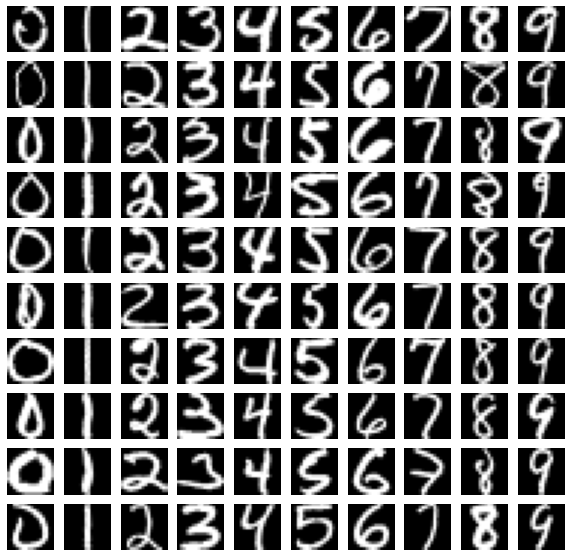

In [7]:
num_samples = 10
num_classes = len(set(y_tr))

classes = set(y_tr)
num_classes = len(classes)
fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_tr == label)
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        ax[i, label].imshow(X_tr[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()

# Normalizing the data

In [39]:
normalize  = True

In [41]:
import preprocessing_ml as preml

scaler = preml.get_scaler("normal_dist")
scaler.fit(X_train)

if normalize:
    X_train = preml.scale_df(
        X_train,
        scaler_trained=scaler,
        verbose = True)

    X_test = preml.scale_df(
        X_test,
        scaler_trained=scaler,
        verbose = True)

scaler = StandardScaler()
scaler = StandardScaler()


# Example of building a classifier on data

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X=X_train, y=y_train)

preds = knn_clf.predict(X_test)
accuracy = sum((preds == y_test))/len(y_test)
print("Accuracy of KNN, ", accuracy)

Accuracy of KNN,  0.9272546088689586


# ---- Running Dimensionality Reductions ---

In [56]:
"""
Will try 3 dimensionality reduction techniques: 
1) PCA: maximizes the variance
2) Isomap: eigenvector decomposition of a pairwise distance
matrix  that is doubly centered
3) Laplacian eigenmaps: eigenvector decomposition
   of the Laplacian of a graph of X where the edges weights are 
   the similarity between points

"""
import dimensionality_reduction_ml as dru
from sklearn import decomposition,manifold

In [77]:
X = X_train
y = y_train
n_components = 3

In [78]:
%matplotlib notebook

# a) PCA

<IPython.core.display.Javascript object>


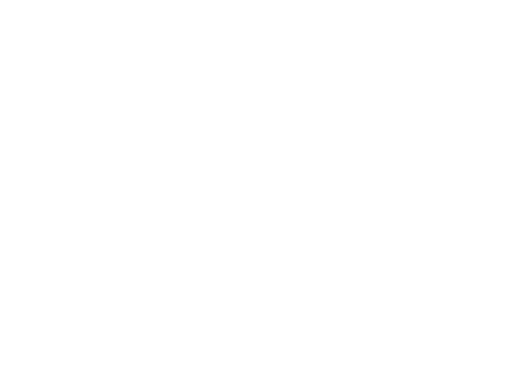

<IPython.core.display.Javascript object>


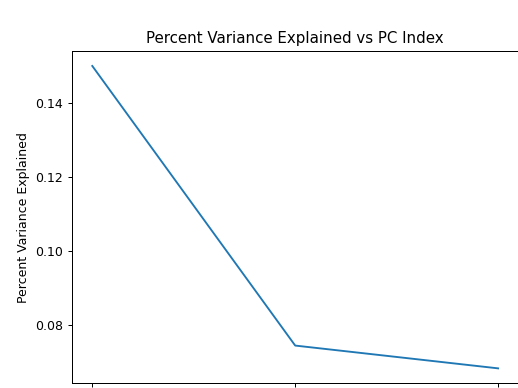

In [79]:
dim_red_name = "PCA"
model_pca = decomposition.PCA(n_components=n_components,whiten=False)
model_pca.fit(X)
X_trans = model_pca.transform(X)

dru.plot_variance_explained(pca_model = model_pca)

#plotting the data


<IPython.core.display.Javascript object>


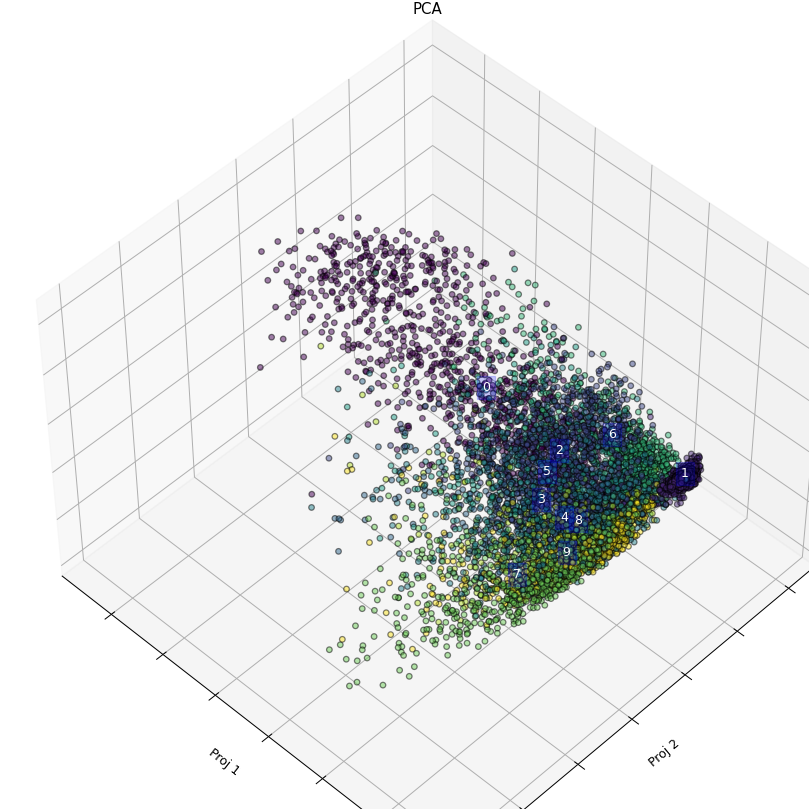

In [80]:
dru.plot_projected_data(
   X_trans,
   labels = y,
   title = f"{dim_red_name}",
    use_labels_as_text_to_plot = True,
   
)

# b) Isomap

In [86]:
import time
verbose = True

<IPython.core.display.Javascript object>


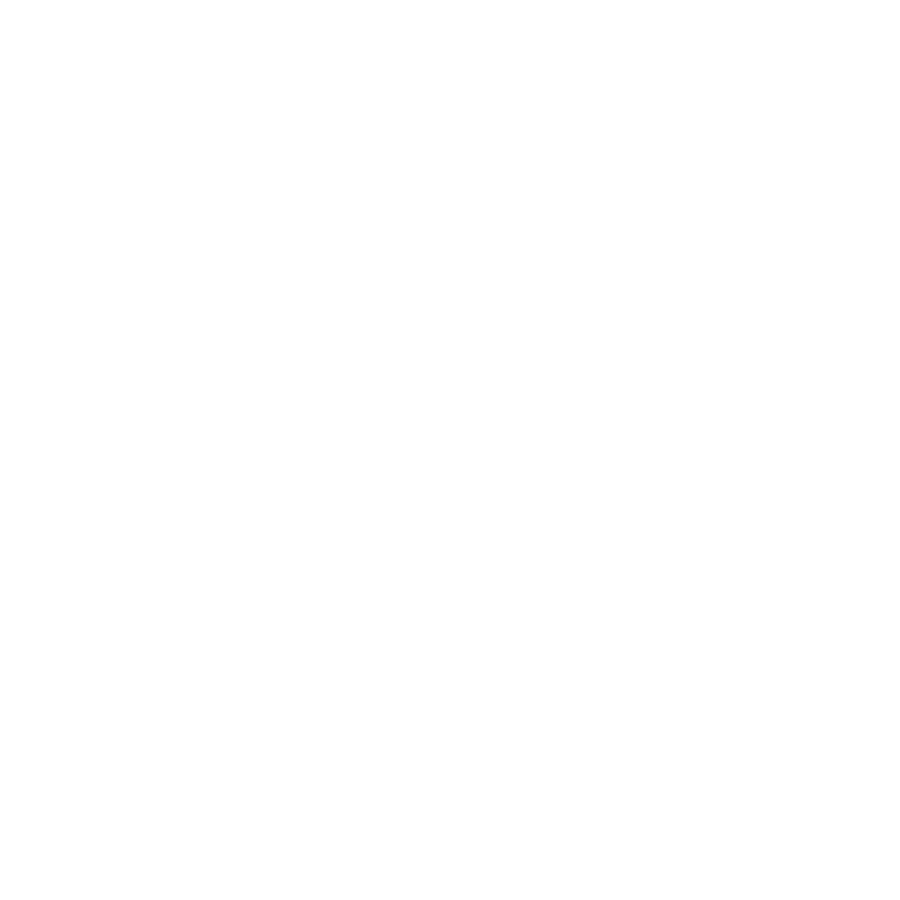

Time for fitting non-linear embedding Isomap: 144.52783679962158


In [87]:
st = time.time()

dim_red_name = "Isomap"
model_func = manifold.Isomap

st = time.time()

model = model_func(n_components=n_components)
model.fit(X)
X_trans = model.transform(X)

dru.plot_projected_data(
   X_trans,
   labels = y,
   title = f"{dim_red_name}",
    use_labels_as_text_to_plot = True,
   
)

if verbose:
    print(f"Time for fitting non-linear embedding {dim_red_name}: {time.time() - st}")

# c) LaPlacian Eigenmaps

In [91]:
dim_red_name = "Laplacian Eigenmaps"
model_func = manifold.SpectralEmbedding

st = time.time()

model = model_func(n_components=n_components)
X_trans = model.fit_transform(X)

dru.plot_projected_data(
   X_trans,
   labels = y,
   title = f"{dim_red_name}",
    use_labels_as_text_to_plot = True,
   
)

if verbose:
    print(f"Time for fitting non-linear embedding {dim_red_name}: {time.time() - st}")

Time for fitting non-linear embedding Laplacian Eigenmaps: 148.30930995941162


In [93]:
dru.plot_projected_data(
   X_trans,
   labels = y,
   title = f"{dim_red_name}",
    use_labels_as_text_to_plot = True,
   
)

# Clustering

In [94]:
from sklearn.cluster import KMeans
n_clusters = 10

clf = KMeans(n_clusters=n_clusters,
                random_state=0)

clf.fit(X_trans)
y_pred = clf.labels_

accuracy = np.sum(y == y_pred)/len(y_pred)
print(f"accuracy = {accuracy}")

accuracy = 0.06597174598820464


# Metrics on How good the clustering was

In [ ]:
"""
Metrics we will use to compute how good the 
clustering algorithm did on top of the non linear embedding

1) Purity: the average overlap of each cluster with the best fit class 
    (bad for imbalanced datasets and favors small clusters)

2) Mutual Information: computes the mutual information of the clusters 
learned and the true clusters (while being normallied by the entropy of the clusters)

3) (adjusted) Rand index: Pairwise agreements of cluster assignments that were correct divided by 
all possible pairwise combinations
(if adjusted then just compare to the expected value if random)
"""

In [100]:
import clustering_ml as clu

metric_funcs =["purity_score","normalized_mutual_info_score","adjusted_rand_score"]

metric_output = dict([(metric_name,getattr(clu,metric_name)(labels_true = y,labels_pred = y_pred)) 
                      for metric_name in metric_funcs])
metric_output
    

{'purity_score': 0.5479358112741737,
 'normalized_mutual_info_score': 0.4899222656200297,
 'adjusted_rand_score': 0.37677515439743114}

# Looping through the dimensionality reduction 

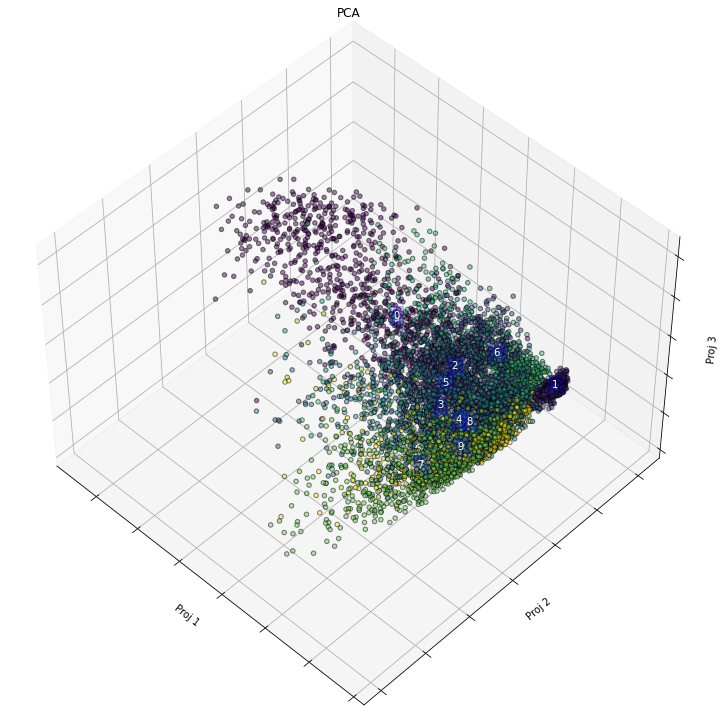

Time for fitting non-linear embedding PCA: 1.3221468925476074


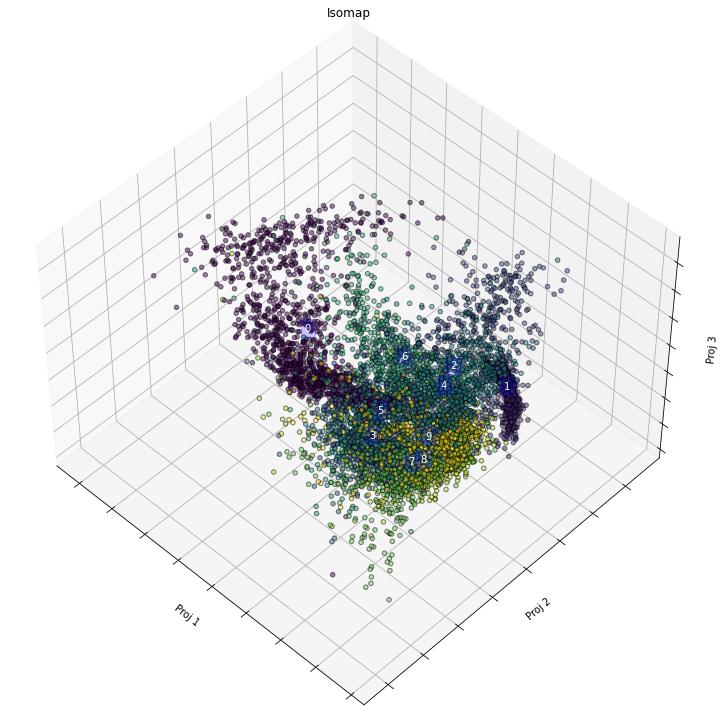

Time for fitting non-linear embedding Isomap: 94.53153681755066


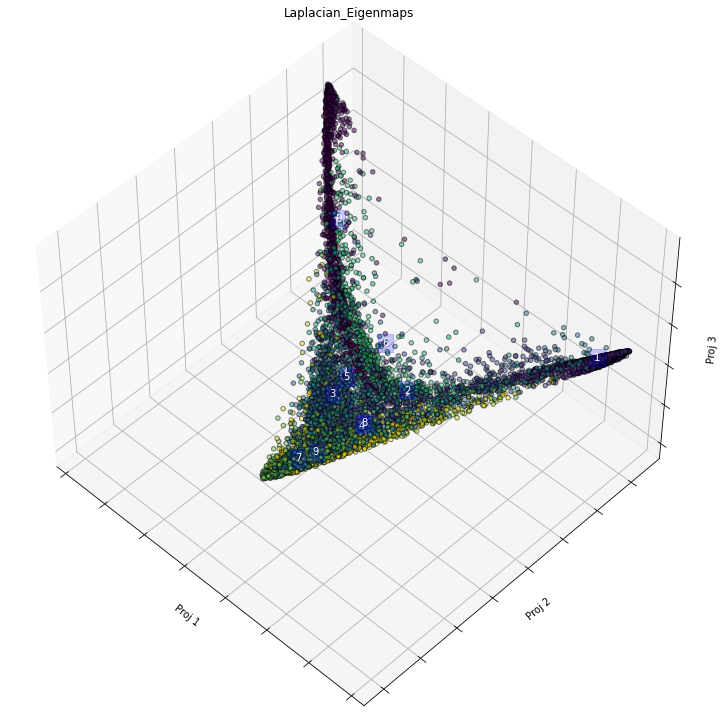

Time for fitting non-linear embedding Laplacian_Eigenmaps: 150.85530257225037


In [103]:
%matplotlib inline

dim_red_methods = dict(
    PCA = decomposition.PCA,
    Isomap =manifold.Isomap,
    Laplacian_Eigenmaps = manifold.SpectralEmbedding,

)

metric_funcs =["purity_score","normalized_mutual_info_score","adjusted_rand_score"]


verbose = True
plot_projections = True
n_clusters = 10

dim_results = []

for dim_red_name,model_func in dim_red_methods.items():
    st = time.time()

    model = model_func(n_components=n_components)
    X_trans = model.fit_transform(X)

    if plot_projections:
        dru.plot_projected_data(
           X_trans,
           labels = y,
           title = f"{dim_red_name}",
            use_labels_as_text_to_plot = True,

        )
        
    #running the clustering:
    clf = KMeans(n_clusters=n_clusters,
                random_state=0)

    clf.fit(X_trans)
    y_pred = clf.labels_
    
    projection_output = dict(
        X_trans = X_trans,
        y_pred = y_pred
    )
    
    metric_output = dict([(metric_name,getattr(clu,metric_name)(labels_true = y,labels_pred = y_pred)) 
                      for metric_name in metric_funcs])
    
    output_dict = dict(name = dim_red_name,
                      n_components = n_components)
    for k in [projection_output,metric_output]:
        output_dict.update(k)
        
    dim_results.append(output_dict)

    if verbose:
        print(f"Time for fitting non-linear embedding {dim_red_name}: {time.time() - st}")

In [104]:
df_results = pd.DataFrame.from_records(dim_results)
df_results

,name,X_trans,y_pred,purity_score,normalized_mutual_info_score,adjusted_rand_score
0,PCA,"[[4.470875, -8.397709, -2.125987], [10.537873,...","[9, 8, 1, 2, 9, 1, 1, 0, 8, 0, 1, 9, 0, 0, 4, ...",0.540392,0.422959,0.331145
1,Isomap,"[[37.73499532453089, -19.14728552785477, -13.1...","[7, 9, 6, 4, 1, 9, 1, 0, 3, 0, 2, 1, 0, 0, 4, ...",0.637498,0.556534,0.447853
2,Laplacian_Eigenmaps,"[[0.0005814589125692912, -0.000321540592070709...","[7, 7, 6, 3, 5, 5, 5, 4, 8, 4, 3, 0, 4, 4, 1, ...",0.547936,0.489922,0.376775


In [105]:
df_results = df_results[["name","n_components","purity_score","normalized_mutual_info_score","adjusted_rand_score"]]
df_results

,name,n_components,purity_score,normalized_mutual_info_score,adjusted_rand_score
0,PCA,3,0.540392,0.422959,0.331145
1,Isomap,3,0.637498,0.556534,0.447853
2,Laplacian_Eigenmaps,3,0.547936,0.489922,0.376775
